In [ ]:
import argparse
import os
import pickle
import string
import time

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy

from scipy import linalg

# Helper functions to generate validation splits

In [ ]:
def get_n_walk_step_walking_splits(train_leng, train_slider_leng, folds_count = 5, validation_leng = None):
    results = []

    # take biggest step s.t. we don't overstep the boundary
    step_size = (train_leng - train_slider_leng - validation_leng) // (folds_count - 1)

    accum_step = 0

    rem = (train_leng - train_slider_leng - validation_leng) % (folds_count - 1)

    for i in range(folds_count):
        results.append(
            {
                "exclude_train_range_start" : (0, accum_step ),
                "exclude_train_range_end":    (accum_step + train_slider_leng, train_leng),

                "exclude_range" : (accum_step + train_slider_leng, accum_step + train_slider_leng + validation_leng),
                "exclude_range_end": (0, accum_step),
                "exclude_block": i,

                "train_range_start": (accum_step, accum_step + train_slider_leng),
                "train_range_end": (3000, 2000),
            }
        )

        accum_step += step_size + (1 if i < rem else 0)
    return results

def get_fast_n_fold_splits(train_leng, validation_leng, folds_count = 5):
    # skip the beginning
    results = []

    step_size = (train_leng  - validation_leng) // (folds_count - 1)

    rem = (train_leng  - validation_leng) % (folds_count - 1)

    accum_step = 0
    for i in range(folds_count):
        results.append(
            {
                "exclude_train_range_start" : ( accum_step, accum_step + validation_leng),
                "exclude_train_range_end" : (3000, 2000),

                "exclude_range" : (accum_step, accum_step + validation_leng),
                "exclude_range_end": (0, 0),
                "exclude_block": i,

                "train_range_start": (0, accum_step),
                "train_range_end": (accum_step + validation_leng, train_leng),
            }
        )
        accum_step += step_size + (1 if i < rem else 0)
    return results

def get_out_of_sample_fold_split(train_leng, validation_leng):

    results = [
        {
            "exclude_train_range_start": (train_leng - validation_leng, train_leng),
            "exclude_train_range_end": (3000, 2000),

            "exclude_range": (train_leng - validation_leng, train_leng),
            "exclude_range_end": (0, 0),
            "exclude_block": 0,

            "train_range_start": (0, train_leng - validation_leng),
            "train_range_end": (3000, 2000),
        }
    ]

    return results

def get_n_widening_fold_splits(train_leng, folds_count = 5, initial_length=0, validation_leng = None):
    results = []

    # take biggest step s.t. we don't overstep the boundary
    step_size = (train_leng -  validation_leng - initial_length) // (folds_count - 1)
    rem = (train_leng -  validation_leng - initial_length) % (folds_count - 1)

    accum_step = initial_length
    for i in range(folds_count):
        results.append(
            {
                "exclude_train_range_start" : ( accum_step, train_leng),
                "exclude_train_range_end" : (3000, 2000),

                "exclude_range" : ( accum_step,  accum_step + validation_leng),
                "exclude_range_end": (0, 0),

                "train_range_start": (0,  accum_step),
                "train_range_end": (3000, 2000),

                "exclude_block": i,
            }
        )
        accum_step += step_size + (1 if i < rem else 0)
    return results

In [ ]:
use_global_reg = True # Flag indicating whether to use constant reg degree among folds

valid_method = "standard"

initLen = 0
inSize = 1
outSize = 1

testLen = 123
trainLen = 1260 - initLen

train_slider_leng =  trainLen // 2

measures_dict = {}

In [ ]:
import pandas as pd
import time
import itertools

data = np.random.random((trainLen * 2, 2))
data_y_col = data[:,1]

# valid, test pairs
every_measur = []

a, eigen, reg = 0.5, 0.5, 1e-8

repeat_cnt = 1
k_range = range( 2, (trainLen + 1), 1 )
res_sizes = [50, 500]
method_version = ["icann", "new", "direct"]

############################################ Beginning #######################################################
for idx, k, res_size, method_version in list(itertools.product( range(0, repeat_cnt), k_range, res_sizes, method_version)):
  if trainLen % k != 0:
    continue
  
  validation_leng = trainLen // k # k parameter

  if valid_method == "standard":
      splits = get_fast_n_fold_splits(trainLen,folds_count=k,validation_leng=validation_leng)
  elif valid_method == "widening":
      splits = get_n_widening_fold_splits(trainLen,folds_count=k,validation_leng=validation_leng)
  elif valid_method == "OOS":
      splits = get_out_of_sample_fold_split(trainLen,validation_leng=validation_leng)
  elif valid_method == "walkforward":
      splits = get_n_walk_step_walking_splits(trainLen, train_slider_leng=train_slider_leng, folds_count=k, validation_leng=validation_leng)

  ###################################### Generate matrices #################################################
  np.random.seed(42)

  eye = np.eye(1+inSize + res_size)

  Win = (np.random.rand(res_size, 1 + inSize) - 0.5) * 1
  W = np.random.rand(res_size, res_size) - 0.5

  rhoW = max(abs(linalg.eig(W)[0]))
  W *= eigen / rhoW

  # allocated memory for the design (collected states) matrix
  X = np.zeros((1 + inSize + res_size, trainLen))
  # set the corresponding target matrix directly
  Yt = data_y_col[None, initLen + 1:trainLen + initLen + 1]

  # run the reservoir with the data and collect X
  x = np.zeros((res_size, 1))
  init_x = np.zeros((res_size,1))
  
  start_time = time.clock()

  operations_req = 0
  ############################################## Collect states ################################################3#
  for t in range(initLen+trainLen):
      u = data_y_col[t]

      x = (1 - a) * x + a * np.tanh(np.dot(Win, np.vstack((1, u))) + np.dot(W, x))
      if t >= initLen:
          X[:, t - initLen] = np.vstack((1, u, x))[:, 0]
      if t == initLen - 1:
          init_x = copy.deepcopy(x)
  ################################################################################################################
  X_T = X.T

  XXT = np.dot(X, X_T)
  Ytarg_XT = np.dot(Yt, X_T)

  XiXti_mats = []      # list holding X_i . X_i^T matrices.
  Ytargi_XiT_mats = [] # list holiding Y_targ_i . X_i^T matrices

  # It's actually not neccessary to run this loop here below, but it makes code clearer
  if method_version in ["icann", "new"]:
    for split in splits:
        idxes = np.r_[split["exclude_train_range_start"][0] : split["exclude_train_range_start"][1], split["exclude_train_range_end"][0] : split["exclude_train_range_end"][1]]

        X_i = X[:, idxes]
        X_iT = X_i.T

        if method_version == "icann":
          XiXti_mats.append(np.dot(X_i, X_iT))

        Y_targ_i = Yt[:, idxes]
        Ytargi_XiT_mats.append(np.dot(Y_targ_i, X_iT))

  best_valid_mse = 1e9

  average_Wout = np.zeros((outSize, 1 + res_size + inSize))
  best_Wout = np.zeros((outSize, 1 + res_size + inSize))

  if method_version == "new":
      XXt_inversed = linalg.inv(XXT + reg * eye)

  for split_id, split in enumerate(splits):   # doing the N-fold CV

      if method_version in ["icann", "new"]:
        leftover_Yt_XT = Ytarg_XT - Ytargi_XiT_mats[split_id]

        if method_version == "new":
            # We assume that X matrix is saved. If T is too big, we can alternatively iterate the sequence again and
            # collect needed X_i states

            idxes = np.r_[split["exclude_train_range_start"][0] : split["exclude_train_range_start"][1], split["exclude_train_range_end"][0] : split["exclude_train_range_end"][1]]

            X_i = X[:, idxes]
            X_iT = X_i.T

            inversed = XXt_inversed + np.dot(np.dot(np.dot(XXt_inversed, X_i), np.linalg.inv(np.eye(len(idxes)) - np.dot(np.dot(X_iT, XXt_inversed), X_i))), np.dot(X_iT, XXt_inversed))
        elif method_version == "icann":
            leftover_XXt = XXT - XiXti_mats[split_id]

            inversed = linalg.inv(leftover_XXt + reg * eye)
        Wout = np.dot(leftover_Yt_XT, inversed)

      elif method_version == "direct":
        take_range = np.r_[split["train_range_start"][0]:split["train_range_start"][1], split["train_range_end"][0]:split["train_range_end"][1]]
        X_this = X[:,take_range]
        X_this_T = X_this.T
        Yt_this = Yt[:,take_range]
        
        Wout = np.dot(np.dot(Yt_this, X_this_T), linalg.inv(np.dot(X_this, X_this_T) + reg * eye))

      average_Wout += Wout

      if split["exclude_range"][0] - 1 <= 0:
          x = copy.deepcopy(init_x)
      else:
          x = np.expand_dims(X[1+inSize:,split["exclude_range"][0] - 1],1)

      ########################### Validate on excluded fold thingie => generative mode #######################
      valid_preds = np.zeros((outSize, split["exclude_range"][1]-split["exclude_range"][0])) # non inclusive
      u = data_y_col[initLen + split["exclude_range"][0]]

      for t in range(valid_preds.shape[1]):
          x = (1 - a) * x + a * np.tanh(np.dot(Win, np.vstack((1, u))) + np.dot(W, x))
          y = np.dot(Wout, np.vstack((1, u, x)))
          valid_preds[:, t] = y
          # generative mode:
          u = y
  ########################################################################################################
  key = (k, res_size, method_version)
  if key not in measures_dict:
    measures_dict[key] = []
  
  measures_dict[key].append(time.clock() - start_time) 



In [ ]:
# from matplotlib import rcParams
# rcParams['text.usetex'] = True

{'icann': {50: {2: 0.17301400000000022, 3: 0.27603500000000025, 4: 0.27623900000000035, 5: 0.28424799999999806, 6: 0.272829999999999, 7: 0.28471199999999897, 9: 0.27591199999999816, 10: 0.27388399999999535, 12: 0.2657480000000021, 14: 0.2827529999999996, 15: 0.27985400000000027, 18: 0.288140999999996, 20: 0.28109000000000606, 21: 0.31995399999999563, 28: 0.2835380000000072, 30: 0.2909489999999977, 35: 0.299997999999988, 36: 0.2969280000000083, 42: 0.3067209999999818, 45: 0.31218599999999697, 60: 0.3193499999999858, 63: 0.32053999999999405, 70: 0.35546099999999115, 84: 0.3215800000000115, 90: 0.33882299999999077, 105: 0.35564099999999144, 126: 0.3613369999999918, 140: 0.38045199999999113, 180: 0.40989700000000084, 210: 0.41416900000001533, 252: 0.45109100000001945, 315: 0.49925400000000764, 420: 0.5825519999999642, 630: 0.6652759999999489, 1260: 1.1447990000000345}, 500: {2: 0.9772940000000006, 3: 1.0276820000000004, 4: 1.1553180000000012, 5: 1.1933149999999983, 6: 1.1819249999999997, 7

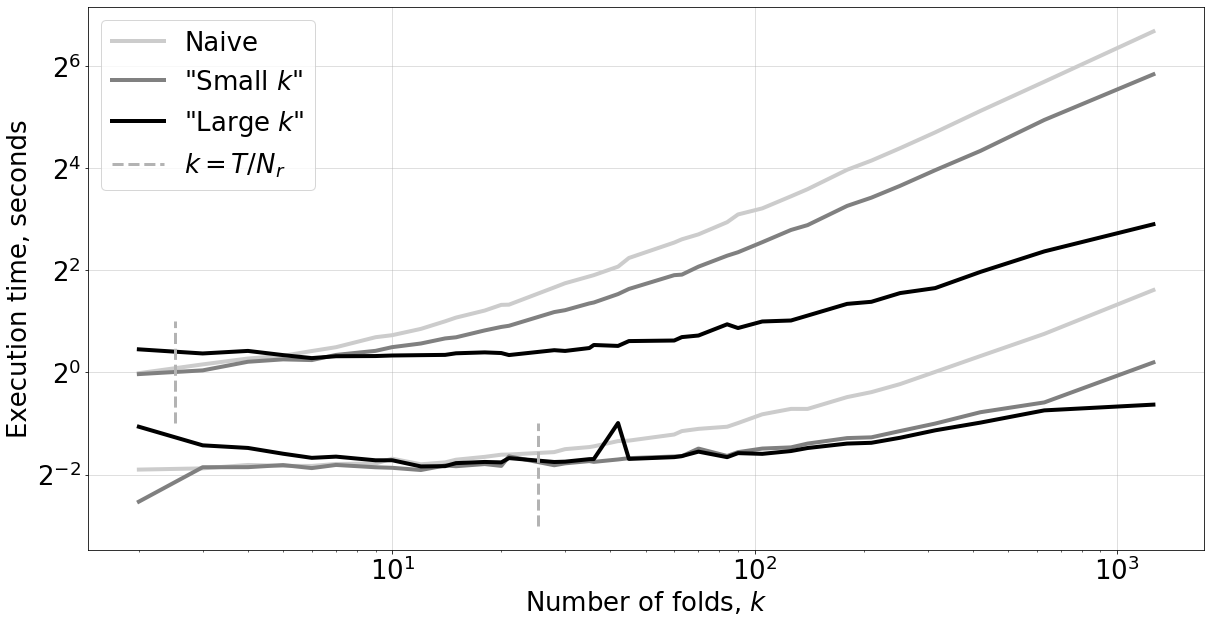

In [6]:
font = {'size'   : 26}
plt.rc('font', **font)
plt.figure(figsize=(20, 10))

formed_measures = {}

colors = [(0.8,0.8,0.8), (.5,.5,.5), (0,0,0), ]
styles = ["-", "-", "-"]

for key, val in measures_dict.items():
  if key[2] not in formed_measures:
    formed_measures[key[2]] = {}
  if key[1] not in formed_measures[key[2]]:
    formed_measures[key[2]][key[1]] = {}
  if key[0] not in formed_measures[key[2]][key[1]]:
     formed_measures[key[2]][key[1]][key[0]] = {}
  formed_measures[key[2]][key[1]][key[0]] = np.mean(val)

rename = {'direct':'Naive', 'icann':'"Small $k$"', 'new':'"Large $k$"', 'thresh':'$k = T/N_r$', '':'' }
# ['"Smalk $k$"','$k = T/N_r$','"Large $k$"','Naive']

print(formed_measures)
#for method_idx, (method_name, method_vals) in enumerate(formed_measures.items()):
for method_idx, method_name in enumerate(['direct', 'icann', 'new', ]):  
  method_vals = formed_measures[method_name]
  for R_idx, (R, R_vals) in enumerate(method_vals.items()):
    #if R == 500: continue
    name = method_name if R_idx == 0 else ""

    vals = sorted(R_vals.items())
    x_vals, y_vals = zip(*vals)

    plt.loglog(x_vals, y_vals, styles[method_idx], linewidth=4, label=rename[name], basey=2, color=colors[method_idx])

    optimal_k = get_optimal_k(R, trainLen)

plt.plot(np.array([1.,1.])*(trainLen/50),[0.125,0.5],linestyle="--", linewidth=3, color=(.7,.7,.7) )
plt.plot(np.array([1.,1.])*(trainLen/500),[0.5,2],linestyle="--", linewidth=3, color=(.7,.7,.7), label='$k = T/N_r$' )

plt.xlabel("Number of folds, $k$")
plt.ylabel("Execution time, seconds")

plt.grid(True, which="major", zorder=3, alpha=0.5)
plt.legend()

plt.text(50,0.75,'$N_r=50$',bbox=dict(boxstyle='square', fc="w", ec="gray"))
plt.text(5,3,'$N_r=500$',bbox=dict(boxstyle='square', fc="w", ec="gray"))

#plt.savefig("gra.pdf", bbox_inches='tight', pad_inches=0)

In [ ]:
!lscpu

Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              2
On-line CPU(s) list: 0,1
Thread(s) per core:  2
Core(s) per socket:  1
Socket(s):           1
NUMA node(s):        1
Vendor ID:           GenuineIntel
CPU family:          6
Model:               85
Model name:          Intel(R) Xeon(R) CPU @ 2.00GHz
Stepping:            3
CPU MHz:             2000.170
BogoMIPS:            4000.34
Hypervisor vendor:   KVM
Virtualization type: full
L1d cache:           32K
L1i cache:           32K
L2 cache:            1024K
L3 cache:            39424K
NUMA node0 CPU(s):   0,1
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_si

In [ ]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.

